# Instrument Classification

Perform segment-based classification of audio signals to five classes of musical instruments. To complete this task, you must:
- Extract low-level timbral descriptors.
- Perform dimensionality reduction.
- Train the selected classifier.
- Use appropriate cross evaluation methods and report results using the standard accuracy metric averaged across evaluation folds.

## Downloading and importing the python packages via pip
Make sure to change the run parameters `python_v='python3'` and `pip_v='pip3` according to the commands appropriate for your python version.
If running conda, look at the setup script to see what libraries are required or print the list of packages `setup.packages`.
```

In [1]:
import setup
python_v = 'python3'
pip_v = 'pip3'
!{python_v} -m pip install --upgrade pip
for i in setup.packages:
    !{pip_v} install {i}

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.5/159.5 kB 7.4 

In [1]:
# Import python packages required
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchaudio
from torchsummary import summary
import pandas as pd
import os
from tqdm import tqdm
import librosa
from python_speech_features import logfbank, mfcc
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from scipy.io import wavfile

## Pre-Processing the data

### Cleaning the dataset
Cutting silence from the audio using an envelope and resampling at 16000, then saving these new files to a 'clean' directory.

In [2]:
# Defining the path constants used
AUDIO_FILES = 'wavfiles'
CLEAN_FILES = 'clean'

def envelope(y, fs, threshold):
	'''
	Envelope function to define a mask where the audio goes below a threshold.

	Parameters:
		y (numpy array): The input signal.
		fs (int): The sampling rate of the signal.
		threshold (float): The threshold of where the mask will activate.
	Returns:
		(list): A mask of boolean values.
	'''
	mask = []
	# Applying the absolute function on the input signal
	y = pd.Series(y).apply(np.abs)
	# Getting the rolling average amplitude using windowing
	y_mean = y.rolling(window=int(fs/16), min_periods=1, center=True).mean()
	for mean in y_mean:
		if mean > threshold:
			mask.append(True)
		else:
			mask.append(False)
	return mask

clean_files = os.listdir(CLEAN_FILES)
for file in tqdm(clean_files):
	# Ignoring files already cleaned and all the 'hidden' files (such as .DS_store used for MacOS)
	if (file in clean_files) or (file[0] == '.'):
		continue
	# Loading the audio file at 16000 Hz
	signal, fs = librosa.load(os.path.join(AUDIO_FILES, file), mono=True, sr=16000)
	# Getting the mask envelope for the audio
	mask = envelope(signal, fs, 0.0005)
	# Writing this masked and resampled audio into the clean directory
	wavfile.write(filename=os.path.join(CLEAN_FILES, file), rate=fs, data=signal[mask])

100%|██████████| 100/100 [00:00<?, ?it/s]


## Annotation File

The code below creates an annotations file which provides the information for the dataset including the filenames and class labels.

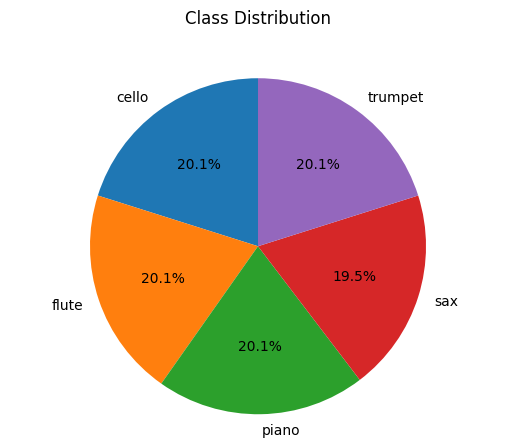

In [4]:
def create_file_annotations():
	'''
	Creates a pandas dataframe which holds the annotations of the audio dataset.
	
	Returns:
		(pandas.DataFrame): The dataframe which can then be stored in a .csv file
	'''
	data = []

	# Walking through the files in the dataset
	for (dirpath, dirnames, filenames) in os.walk(CLEAN_FILES):
		for filename in filenames:
			# Extracting the filename and class label
			class_name = filename.split('-')[0]
			data.append([filename, class_name])
		break

	# Creating a pandas dataframe to hold this data
	df = pd.DataFrame(data, columns=['Filename', 'ClassLabel'])

	# Create class ID numbers from the class labels for unique classes
	df['ClassID'] = df.groupby(['ClassLabel']).ngroup()

	# Create length in seconds column
	df.set_index('Filename', inplace=True)
	for record in df.index:
		signal, fs = librosa.load(os.path.join(CLEAN_FILES, record), mono=True, sr=None)
		df.at[record, 'Length'] = signal.shape[0]/fs

	return df

annotations = create_file_annotations()

# Save the dataframe to a CSV file
annotations.to_csv(path_or_buf="annotations.csv", sep=',', encoding='utf-8', index=False)

# Getting the class distribution
class_dist = annotations.groupby(['ClassLabel'])['Length'].mean()

# Plotting the distribution
fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%', shadow=False, startangle=90)
ax.axis('equal')
plt.show()
annotations.reset_index(inplace=True)

## Custom Dataset

The custom dataset imports the audio dataset's annotation file into python and uses it to load the correct audio files with the corresponding class labels.

In [7]:
class AudioDataset(Dataset):
  ''' Custom Dataset class for audio instrument classification '''

  def __init__(self, annotation_file, audio_dir, device, transformation, transform_fs, num_samples):
    '''
    Parameters -
        annotation_file (str): a path to a csv file with the annotations for the dataset
                            these annotations should have the filename at index 0 and class ID at -1
        audio_dir (str): the path to the audio dataset directory
        device (torch.device): the device in use (cuda or cpu)
        transformation (torch.transforms): provides the function for performing preprocessing on the data
        transform_fs (int): the samplerate to resample at
        num_samples (int): the length n of samples to cut / pad the data to
    '''
    # Read in the annotation file for the dataset
    self.annotations = pd.read_csv(annotation_file)

    # Defining attributes
    self.audio_dir = audio_dir
    self.device = device
    self.transformation = transformation.to(self.device) # putting the data onto a cuda device is available
    self.transform_fs = transform_fs
    self.num_samples = num_samples

    # Creating a unique ID for the classes
    # self.annotations.assign(id=self.annotations.groupby(['ClassLabel']).ngroup())

  def __len__(self):
    ''' Magic method to provide the length of the object '''
    return len(self.annotations)

  def __getitem__(self, index):
    ''' Magic method to provide indexing for the object '''

    # Gets the audio path and labelID for the index
    audio_sample_path, labelID = self._get_audio_sample_path_and_label(index)

    # Loads the audio input to the device
    signal, fs = torchaudio.load(audio_sample_path, normalize=True)
    signal = signal.to(self.device)

    # Resamples and reshapes the audio
    signal = self._resample_audio(signal, fs)
    signal = self._reshape_audio(signal)

    # Performs transformation on the device
    signal = self.transformation(signal)

    return signal, labelID

  def get_class_labels(self):
    ''' Public method to provide a list of the class labels '''
    return self.annotations['ClassLabel'].unique()

  def _get_audio_sample_path_and_label(self, index):
      '''
      Private get method for the sample path location
        and prediction labelID
      '''
      label = self.annotations.loc[index, 'ClassLabel']
      labelID = self.annotations.loc[index, 'ClassID']
      path = os.path.join(self.audio_dir, label, self.annotations.loc[index, 'Filename'])
      return path, labelID

  def _resample_audio(self, signal, fs):
      # Resample the audio signal if needed
      if fs != self.transform_fs:
          resampler = torchaudio.transforms.Resample(fs, self.transform_fs).to(self.device)
          signal = resampler(signal)
      return signal

  def _reshape_audio(self, signal):
      # Convert the signal to mono if needed
      if signal.shape[0] > 1:
          signal = torch.mean(signal, dim=0, keepdim=True)

      # Cut the signal if needed
      if signal.shape[1] > self.num_samples:
          signal = signal[:, :self.num_samples]

      # Pad the signal if needed
      if signal.shape[1] < self.num_samples:
          signal = torch.nn.functional.pad(signal, (0, self.num_samples - signal.shape[1]))

      return signal

# Defining the dataset and dataloader constants
SAMPLE_RATE = 22050
NUM_SAMPLES = 22050
BATCH_SIZE = 128

# Creating a mel spectogram for the feature transformation
mel_spectogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=1024,
    hop_length=512,
    n_mels=64
)

# Defining the device being used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device available: {device}")

# Creating the dataset and dataloader
audio_dataset = AudioDataset(f"annotations.csv", AUDIO_FILES, device, mel_spectogram, SAMPLE_RATE, NUM_SAMPLES)
data_loader = DataLoader(audio_dataset, batch_size=BATCH_SIZE)

signal, label = audio_dataset[0]
print(label)
# Printing all the class labels
print(audio_dataset.get_class_labels())

# Checking the dataloader size
print(len(data_loader))

Device available: cpu


KeyError: 'Filename'

## Plotting the signals
Plotting the signal in the time domain, Fast Fourier Transform, Filter bank Spectrum and Mel Frequency Cepstrum.

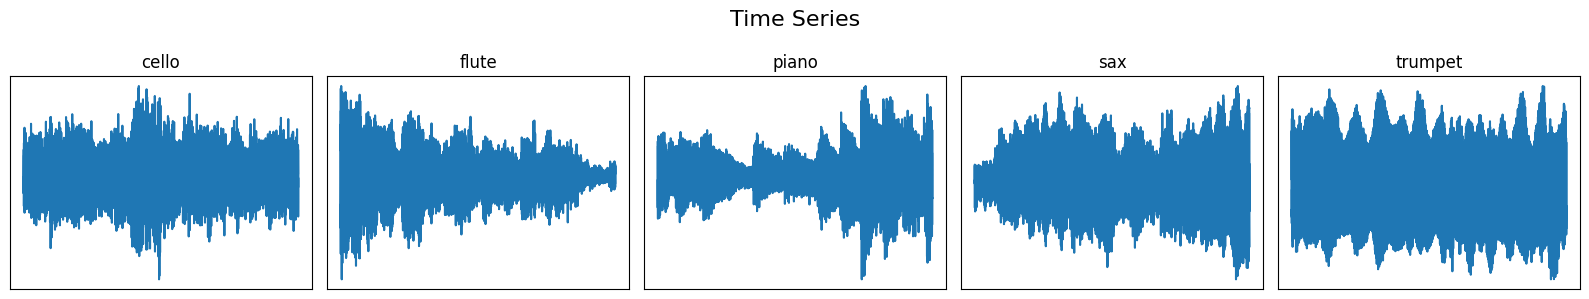

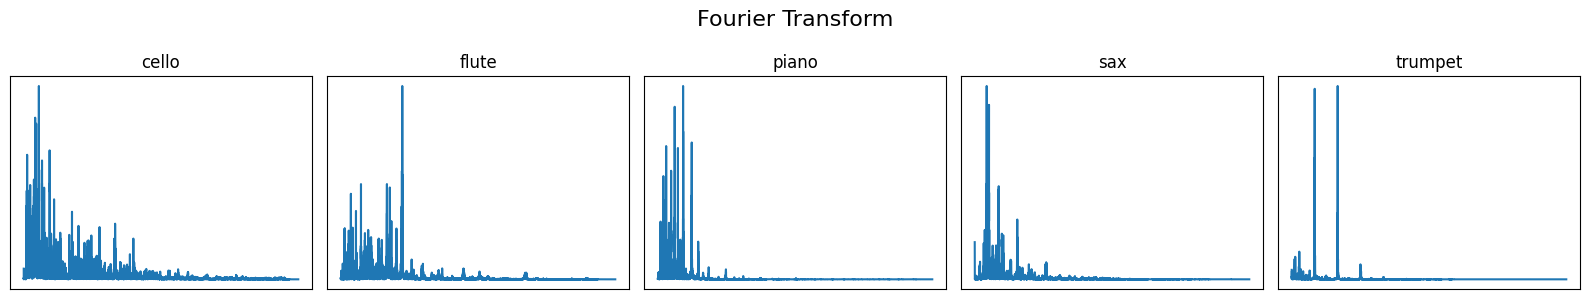

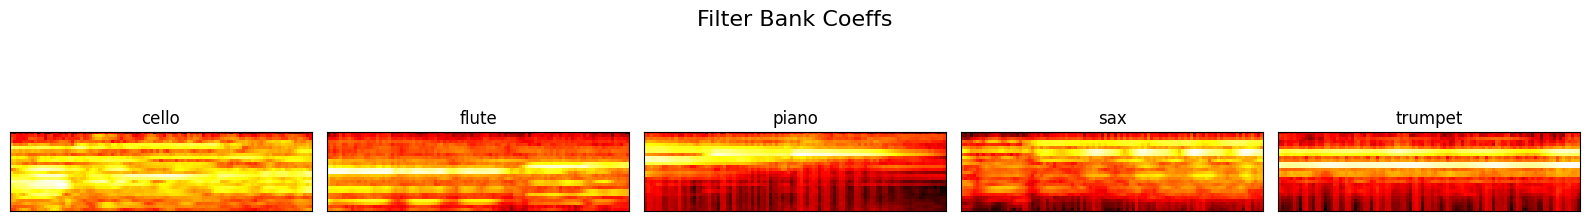

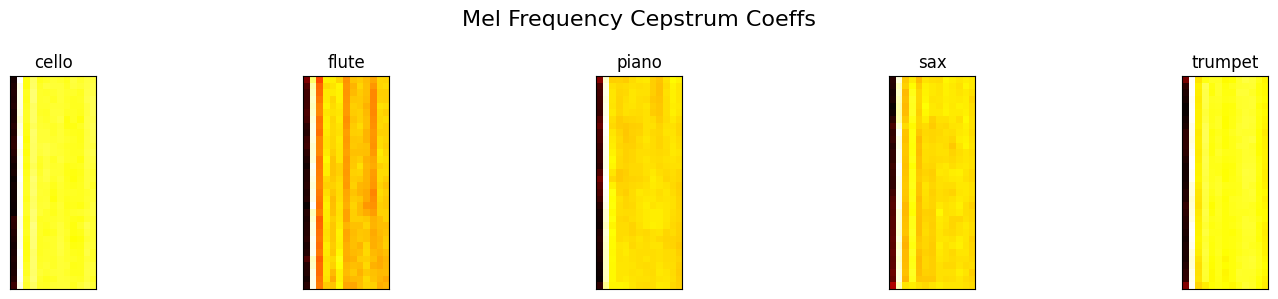

In [9]:
def calc_fft(y, fs):
	'''
	Calculates the Fast Fourier Transform of a signal.

	Parameters:
		y (numpy array): The input signal.
		fs (int): The sampling rate of the signal.
	Return:
		(tuple): The magnitude values and frequency bins (1/sample rate).
	'''
	n = len(y)
	freqs = np.fft.rfftfreq(n, d=1/fs)
	Y = abs(np.fft.rfft(y)/n)
	return (Y, freqs)

def plot_signals_time(signals):
	'''
	Plots the time domain of the signals.

	Parameters:
		signals (list): The input signals in a list.
	'''
	
	ncols = len(signals)
	fig, ax = plt.subplots(1, ncols, figsize=(16, 3))
	fig.suptitle("Time Series", size=16)

	z = 0
	for y in range(ncols):
		ax[y].set_title(list(signals.keys())[z])
		ax[y].plot(list(signals.values())[z])
		ax[y].set_xticks([])
		ax[y].set_yticks([])
		ax[y].grid(False)
		z += 1
	
	plt.tight_layout()
	plt.show()

def plot_ffts(signals):
	'''
	Plots the Fast Fourier Transform of the signals.

	Parameters:
		signals (list): The input signals in a list.
	'''
	
	ncols = len(signals)
	fig, ax = plt.subplots(1, ncols, figsize=(16, 3))
	fig.suptitle("Fourier Transform", size=16)

	z = 0
	for y in range(ncols):
		data = list(fft.values())[z]
		Y, freq = data[0], data[1]
		ax[y].set_title(list(signals.keys())[z])
		ax[y].plot(freq, Y)
		ax[y].set_xticks([])
		ax[y].set_yticks([])
		ax[y].grid(False)
		z += 1
	
	plt.tight_layout()
	plt.show()

def plot_fbanks(signals):
	'''
	Plots the Filter Bank spectrogram of the signals.

	Parameters:
		signals (list): The input signals in a list.
	'''
	
	ncols = len(signals)
	fig, ax = plt.subplots(1, ncols, figsize=(16, 3))
	fig.suptitle("Filter Bank Coeffs", size=16)

	z = 0
	for y in range(ncols):
		ax[y].set_title(list(signals.keys())[z])
		ax[y].imshow(list(signals.values())[z],
						cmap='hot', interpolation='nearest')
		ax[y].set_xticks([])
		ax[y].set_yticks([])
		ax[y].grid(False)
		z += 1
	
	plt.tight_layout()
	plt.show()

def plot_mfccs(signals):
	'''
	Plots the Mel Frequency Cepstrum of the signals.
	
	Parameters:
		signals (list): The input signals in a list.
	'''
	
	ncols = len(signals)
	fig, ax = plt.subplots(1, ncols, figsize=(16, 3))
	fig.suptitle("Mel Frequency Cepstrum Coeffs", size=16)
	
	z = 0
	for y in range(ncols):
		ax[y].set_title(list(signals.keys())[z])
		ax[y].imshow(list(signals.values())[z],
						cmap='hot', interpolation='nearest')
		ax[y].set_xticks([])
		ax[y].set_yticks([])
		ax[y].grid(False)
		z += 1
	
	plt.tight_layout()
	plt.show()


# Creating dictionaries to hold the data and the corresponding class label as a key
signals = {}
fft = {}
fbank = {}
mfccs = {}

# Getting all the unique class labels
classes = list(np.unique(annotations.ClassLabel))

# Iterating through the classes and selecting the first signal from each to extract features
for c in classes:
  wav_file = annotations[annotations.ClassLabel == c].iloc[0, 0]
  signal, fs = librosa.load(os.path.join(CLEAN_FILES, wav_file), mono=True, sr=None)
  signals[c] = signal
  fft[c] = calc_fft(signal, fs)
  bank = logfbank(signal[:fs], fs, nfilt=26, nfft=1103).T
  fbank[c] = bank
  mel = mfcc(signal[:fs], fs, numcep=13, nfilt=26, nfft=1103).T
  mfccs[c] = mel

# Plotting the feature extractions of the audio
plot_signals_time(signals)
plt.show()

plot_ffts(fft)
plt.show()

plot_fbanks(fbank)
plt.show()

plot_mfccs(mfccs)
plt.show()

## Convolutional Neural Network

Defining the convolutional neural network architecture with the layers and activation functions.

In [20]:
class CNNNetwork(nn.Module):
  ''' Custom Convolution Neural Network for audio classification'''

  def __init__(self, num_classes):
    '''
    Parameters -
        num_classes: the number of classes used for classification
    '''
    super().__init__()

    # Define convolutional blocks
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.conv3 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.conv4 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    # Create a flatten layer to reshape the data into a 1D vector
    self.flatten = nn.Flatten()

    # Create a linear / dense layer to classify the data from the convolutional network
    self.linear = nn.Linear(in_features=128*5*4, out_features=num_classes)

    # Create a softmax layer to provide decimal probabilities to the class predictions
    self.softmax = nn.Softmax(dim=1)

  def forward(self, input_data):
    ''' Passing the data through the network '''
    x = self.conv1(input_data)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.flatten(x)
    logits = self.linear(x)
    predictions = self.softmax(logits)
    return predictions

# Creating the neural network
cnn = CNNNetwork(audio_dataset.get_class_labels().size).to(device)

# Printing a summary of the network
if device == "cuda":
    summary(cnn.cuda(), (1, 64, 44))
else:
    summary(cnn, (1, 64, 44))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 33, 23]          --
|    └─Conv2d: 2-1                       [-1, 16, 66, 46]          160
|    └─ReLU: 2-2                         [-1, 16, 66, 46]          --
|    └─MaxPool2d: 2-3                    [-1, 16, 33, 23]          --
├─Sequential: 1-2                        [-1, 32, 17, 12]          --
|    └─Conv2d: 2-4                       [-1, 32, 35, 25]          4,640
|    └─ReLU: 2-5                         [-1, 32, 35, 25]          --
|    └─MaxPool2d: 2-6                    [-1, 32, 17, 12]          --
├─Sequential: 1-3                        [-1, 64, 9, 7]            --
|    └─Conv2d: 2-7                       [-1, 64, 19, 14]          18,496
|    └─ReLU: 2-8                         [-1, 64, 19, 14]          --
|    └─MaxPool2d: 2-9                    [-1, 64, 9, 7]            --
├─Sequential: 1-4                        [-1, 128, 5, 4]           --
|    └─

## Training

Below demonstrates the function to train the neural network. This then saves the model state to google drive.

In [21]:
def train(model, data_loader, loss_func, optimiser, device, epochs):
  '''
  Parameters -
    model: the model to train
    data_loader: the dataloader to optimise memory storage with batch downloads
    loss_func: the loss function to use to update the bias weightings
    optimiser: the optimiser to use for backwards propogation
    device: the device in use (cuda or cpu)
    epochs: the number of epochs to run
  '''
  model.train()

  # Using a loading bar to show progress
  with tqdm(data_loader, unit="batch", total=len(data_loader)) as tepoch:

    # Increament through each epoch
    for epoch in range(epochs):
      for input, target in data_loader:
        tepoch.set_description(f"Epoch {epoch}")

        # Load the batch input into the device memory
        input, target = input.to(device), target.to(device)

        # Calculate the loss
        output = model(input) # pass the inputs into the model
        loss = loss_func(output, target) # compare the predictions to the actual data

        # Calculate the accuracy of the model to display
        predictions = output.argmax(dim=1, keepdim=True).squeeze()
        correct = (predictions == target).sum().item()
        accuracy = correct / BATCH_SIZE

        # Backpropogate the loss and update the NN weights
        optimiser.zero_grad() # resets the gradients
        loss.backward() # performs back propogation
        optimiser.step() # updates the weights

        tepoch.set_postfix(loss=loss.item(), accuracy=100. * accuracy)

  print("\nTraining Completed")

# Defining network constants
EPOCHS = 40
LEARNING_RATE = .001

# Defining the loss function
loss_func = nn.CrossEntropyLoss()

# Defining the optimiser
optimiser = torch.optim.Adam(cnn.parameters(), lr=LEARNING_RATE)

# Training the model
train(cnn, data_loader, loss_func, optimiser, device, EPOCHS)

# Saving the model state
model_state_path = "cnn.pth"
torch.save(cnn.state_dict(), model_state_path)
print(f"Model trained and stored  at '{model_state_path}'")

Epoch 39:   0%|          | 0/3 [17:55<?, ?batch/s, accuracy=15.6, loss=2]   


Training Completed
Model trained and stored  at 'cnn.pth'


## References

<Bosch2012>Bosch, J. J., Janer, J., Fuhrmann, F., & Herrera, P. (2012). "A Comparison of Sound Segregation Techniques for Predominant Instrument Recognition in Musical Audio Signals." In Proceedings of the International Society for Music Information Retrieval Conference (ISMIR) (pp. 559-564).